In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.optimizers import Nadam, Adam
import matplotlib.pyplot as plt

import numpy as np

#Adjust for how many variables we differentiate. Works well for n = 1, falls apart for n = 2. TODO: Investigate.
n_degrees = 2

#Simple NN.
model = Sequential([
    Dense(128, input_dim=1, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(n_degrees)
])

#Alternative model. Similar to paper.
"""input_layer = Input(shape=(1,))
split_1 = [Dense(32, activation='tanh')(input_layer) for i in range(n_degrees)]
split_2 = [Dense(32, activation='tanh')(split_1[i]) for i in range(n_degrees)]
output_layer = [Dense(1, activation='tanh')(split_2[i]) for i in range(n_degrees)]
model = Model(inputs=input_layer,outputs = output_layer)"""

opt = Adam(learning_rate=0.001)

#Evaluate x, dx/dt, d2x/dt2 for model over time array.
def eval_model(t, model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(t)
            x = tf.concat(model(t, training=True),axis=1)
            dx = tf.concat([tape2.gradient(x[:,i],t) for i in range(n_degrees)],axis=1)
        dx2 = tf.concat([tape.gradient(dx[:,i],t) for i in range(n_degrees)],axis=1)
    return x, dx, dx2

#PINN ODE loss (currently made for system of 2 ODEs for testing. We change this depending on the system and eventually implement an FPU loss)
def ode_loss(t, x, dx, dx2):
    total_ode = []
    total_ode.append(tf.reduce_mean(tf.square(dx[:,0]-x[:,0])))
    total_ode.append(tf.reduce_mean(tf.square(dx[:,1]-5*x[:,1])))
    return tf.norm(total_ode)

#PINN Initial condition loss.
def ic_loss(x, dx, x0, dx0,include_dx=True):
    return tf.reduce_mean(tf.square(x-x0)) + include_dx * tf.reduce_mean(tf.square(dx-dx0))

#Define parameters
n_epochs = 10000

#Define a time grid to train on.
resolution = 512
max_time = 2

time = tf.constant(np.sort(np.random.rand(resolution) * max_time).reshape(-1,1),dtype=tf.float32)

#Debugging variable to store final dx/dt
final_grads = None

#Custom training loop using PINN loss.
for e in range(n_epochs):
    with tf.GradientTape() as tape:
        x, dx, dx2 = eval_model(time, model)
        loss = ode_loss(time,x,dx,dx2) + ic_loss(x[0,:],dx[0],[1,1],[0],include_dx=False)
        #Log loss. Loss should go to around 1e-5 or 1e-6 when it works fairly quickly and continue to converge. Plateaus at around e-1 for multivariate ODEs. TODO: Fix.
        print(loss)
    grad = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad,model.trainable_variables))
    if(e == n_epochs - 1):
        final_grads = dx



tf.Tensor(1.980475, shape=(), dtype=float32)
tf.Tensor(1.5336702, shape=(), dtype=float32)
tf.Tensor(1.2216538, shape=(), dtype=float32)
tf.Tensor(1.051016, shape=(), dtype=float32)
tf.Tensor(1.0066993, shape=(), dtype=float32)
tf.Tensor(1.0404713, shape=(), dtype=float32)
tf.Tensor(1.0965182, shape=(), dtype=float32)
tf.Tensor(1.1283464, shape=(), dtype=float32)
tf.Tensor(1.1190472, shape=(), dtype=float32)
tf.Tensor(1.0736356, shape=(), dtype=float32)
tf.Tensor(1.0073447, shape=(), dtype=float32)
tf.Tensor(0.9380417, shape=(), dtype=float32)
tf.Tensor(0.883919, shape=(), dtype=float32)
tf.Tensor(0.8566955, shape=(), dtype=float32)
tf.Tensor(0.841419, shape=(), dtype=float32)
tf.Tensor(0.82940054, shape=(), dtype=float32)
tf.Tensor(0.8243371, shape=(), dtype=float32)
tf.Tensor(0.8267268, shape=(), dtype=float32)
tf.Tensor(0.830987, shape=(), dtype=float32)
tf.Tensor(0.83118975, shape=(), dtype=float32)
tf.Tensor(0.8247758, shape=(), dtype=float32)
tf.Tensor(0.8129938, shape=(), dtype=

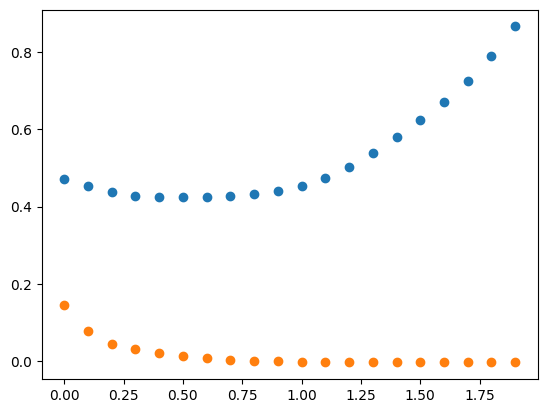

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim

#Evaluate model over discrete time array.
testtime = np.arange(0,max_time,0.1).reshape(-1,1)
x = tf.concat(model(testtime),axis=1)

#Code for rendering animations of multivariate ODEs over time. It works, but no accurate solutions yet.
"""fig, ax = plt.subplots()

def animate(i):
        ax.clear()
        ax.set_ylim(bottom=-2,top=2)
        ax.plot(x[i,:])
        return ax

animator = anim.FuncAnimation(fig, animate, frames=len(testtime),interval=100)
animator.save("preview.mp4",writer='ffmpeg')"""

#Plot (in this case two) output variables of ODE.
plt.scatter(testtime,x[:,0])
plt.scatter(testtime,x[:,1])

In [40]:
def func(t):
    return tf.concat([tf.cos(t),tf.sin(t)],axis=-1)

time = tf.constant(np.linspace(0,2,50))
with tf.GradientTape() as tape:
    tape.watch(time)
    u = func(time)
    u_t = tape.gradient(u,time)
    print(tf.reshape(u,-1,1))
plt.plot(time,u[:,0])


tf.Tensor(
[ 1.          0.99916713  0.9966699   0.99251249  0.9867018   0.97924752
  0.97016207  0.95946058  0.94716088  0.93328345  0.91785141  0.90089048
  0.88242889  0.8624974   0.84112921  0.81835992  0.79422746  0.76877202
  0.742036    0.71406394  0.68490244  0.65460007  0.6232073   0.59077643
  0.55736148  0.52301811  0.48780353  0.45177639  0.41499671  0.37752575
  0.33942593  0.30076072  0.26159452  0.22199256  0.18202083  0.1417459
  0.10123485  0.06055518  0.01977463 -0.02103886 -0.0618173  -0.10249276
 -0.14299751 -0.18326405 -0.22322532 -0.26281476 -0.30196642 -0.34061508
 -0.37869636 -0.41614684  0.          0.04080499  0.08154202  0.12214321
  0.16254095  0.20266794  0.24245733  0.28184285  0.3207589   0.35914064
  0.39692415  0.43404648  0.47044581  0.5060615   0.54083421  0.57470604
  0.60762056  0.63952294  0.67036003  0.70008048  0.72863478  0.75597537
  0.78205669  0.80683531  0.83026995  0.85232157  0.87295345  0.89213121
  0.90982291  0.92599909  0.94063279  0.9

2024-06-02 12:59:55.344006: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Index out of range using input dim 1; input has only 1 dims


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/